In [1]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from analysis import *
from plots import *

%matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [2]:
output_dir = config['output_dir']
output_dir = './psd_channel_groups/'

ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']

### Select sessions for analysis

In [3]:
# # Initialize session list
# from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# manifest_path = os.path.join(config['cache_dir'], "manifest.json")
# cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
# sessions = cache.get_session_table()

# filter_dict = {
#     'session_type': '',
#     'full_genotype': '',
#     'ecephys_structure_acronyms': 'VISp'
#  }
# filtered_sessions = sessions[
#     np.logical_and.reduce([np.array([True if s in x else False for x in sessions[k]]) for k, s in filter_dict.items()])
# ]
# session_list = filtered_sessions.index.to_list()

# session_list_df = {k: v if v else filtered_sessions.loc[session_list, k] for k, v in filter_dict.items()}
# session_list_df = pd.DataFrame(session_list_df, index=pd.Index(session_list, name='session_id'))
# session_list_df.to_csv(os.path.join(output_dir, 'session_list.csv'))

In [4]:
# # Initialize session selection table
# session_list_df = pd.read_csv(os.path.join(output_dir, 'session_list.csv'), index_col='session_id')
# session_selection = session_list_df.copy()
# session_selection['psd good'] = True
# session_selection.to_csv(os.path.join(output_dir, 'session_selection_all.csv'))

In [5]:
# Read session selection
# session_selection_file = 'session_selection'
session_selection_file = 'session_selection_all'

session_selection = pd.read_csv(os.path.join(output_dir, session_selection_file + '.csv'), index_col='session_id')

### Get PSD data from session and probe

In [6]:
psd_ds = {}
for session_id in session_selection.index:
    session_dir = os.path.join(output_dir, f'session_{session_id:d}')
    if session_selection.loc[session_id, 'psd good'] and os.path.isdir(session_dir):
        for probe_dir in os.listdir(session_dir):
            probe_dir = os.path.join(session_dir, probe_dir) if probe_dir.startswith('probe_') else ''
            if  os.path.isdir(probe_dir):
                ecephys_structure_acronyms = session_selection.loc[session_id, 'ecephys_structure_acronyms']
                filename = ecephys_structure_acronyms + '_psd_channel_groups.nc'
                psd_ds[session_id] = xr.load_dataset(os.path.join(probe_dir, filename))
                # # correct variable name
                # psd_ds[session_id] = psd_ds[session_id].rename(drifting_grating='drifting_gratings')
                # psd_ds[session_id] = psd_ds[session_id].rename(frequency_drifting_grating='frequency_drifting_gratings')
                # psd_ds[session_id].to_netcdf(os.path.join(probe_dir, filename))
                break

### Select stimuli

In [7]:
stimuli = ['drifting_gratings', 'natural_movie_three', 'natural_movie_one',
           'drifting_gratings_75_repeats', 'drifting_gratings_contrast',
           'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']

### Calculate average PSD

In [8]:
plt_range = (0, 100.)
freq_range = 200.
aperiodic_mode = 'knee'
dB_threshold = 3.
max_n_peaks = 10
figsize = (3.2, 2.4)


drifting_gratings: 29 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.9697, 128.6697, 2.2650                                     
                                                                                                  
                                       1 peaks were found:                   

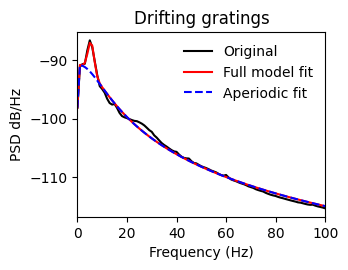


natural_movie_three: 29 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.0114, 15.1397, 1.7509                                     
                                                                                                  
                                       1 peaks were found:                 

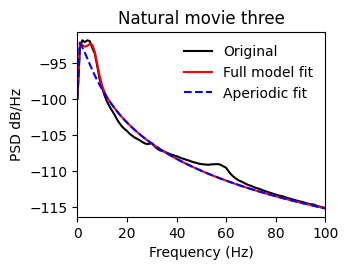


natural_movie_one: 29 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.9939, 16.1245, 1.7571                                     
                                                                                                  
                                       1 peaks were found:                   

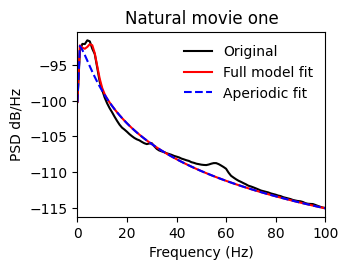


drifting_gratings_75_repeats: 0 sessions

drifting_gratings_contrast: 0 sessions

natural_movie_one_more_repeats: 0 sessions

natural_movie_one_shuffled: 0 sessions


In [9]:
for stim in stimuli:
    # get sessions with stimulus
    stim_ds = [ds for ds in psd_ds.values() if stim in ds]
    print(f'\n{stim}: {len(stim_ds)} sessions')
    if len(stim_ds) == 0:
        continue

    # get frequency array
    freq_coord = f'frequency_{stim:s}'
    f_min = []
    f_max = []
    nf = []
    for ds in stim_ds:
        freq = ds.coords[freq_coord]
        f_min.append(freq.min())
        f_max.append(freq.max())
        nf.append(freq.size)
    freq = np.linspace(np.max(f_min), np.min(f_max), np.min(nf))
    interp_freq = {freq_coord: freq}

    # interpolate psd and average across sessions
    stim_psd = []
    stim_sessions = []
    for ds in stim_ds:
        group_id = ds.attrs['center_unit_group_id']
        stim_sessions.append(ds.attrs['session_id'])
        psd = ds[stim].sel(channel=group_id).interp(interp_freq)
        stim_psd.append(10 * np.log10(psd)) # convert to decibels
    stim_psd = xr.concat(stim_psd, dim=pd.Index(stim_sessions, name='session_id')).rename({freq_coord: 'frequency'})
    psd_avg = 10 ** (stim_psd.mean(dim='session_id') / 10) # convert back to power

    fooof_result = fit_fooof(freq, psd_avg.values,
        aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks,
        freq_range=freq_range, peak_width_limits=None, report=True, plot=False)

    fig, ax = plt.subplots(figsize=figsize)
    psd_avg_plt = psd_avg.sel(frequency=slice(*plt_range))
    _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
    ax.set_title(stim.replace('_', ' ').capitalize())
    plt.show()